In [1]:
%pylab notebook

from datacube import Datacube

from datetime import datetime
import numpy as np
import gc
import warnings

import datacube
from datacube.storage import masking
import xarray as xr
from datacube.helpers import write_geotiff
import rasterio.features
from shapely.geometry import Polygon
import geopandas as gp
from geopandas.tools import sjoin

# Import the custom scripts. These can be found in the dea-notebooks repository.
import sys
import os.path
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts'))
import DEAPlotting
import DEADataHandling
import water_classifier_and_wofs

dc = Datacube(app='pixel_drill')

Populating the interactive namespace from numpy and matplotlib


Failed to resolve driver datacube.plugins.index::s3aio_index


## Select a cropping season

In [2]:
query = {'lat': (-30.310464, -30.748712),
         'lon': (149.681035, 150.169855),
         'time':('2016-10-01', '2017-05-01')
         }

In [3]:
WOFS_TIFF = '/g/data/r78/cek156/dea-notebooks/Crop_mapping/BoggabriNarrabri_WOFS_201617.tif'
WOFS_polygons = '/g/data/r78/cek156/dea-notebooks/Crop_mapping/BoggabriNarrabri_WOFS_201617'

## Load the WOFLs

In [4]:
%%time
WOFL = dc.load(product='wofs_albers', **query)

Failed to resolve driver datacube.plugins.io.read::s3aio
Failed to resolve driver datacube.plugins.io.read::s3aio_test


CPU times: user 7.22 s, sys: 877 ms, total: 8.09 s
Wall time: 15min 12s


## Find only where wet = True

In [5]:
wetWOFL = masking.make_mask(WOFL, wet = True)

## Calculate percentage wet over this season

In [6]:
total_water_obs = wetWOFL.water.sum(dim='time')
total_obs = WOFL.water.sum(dim='time')
wofs = ((total_water_obs/total_obs)*100)

### And plot

<IPython.core.display.Javascript object>


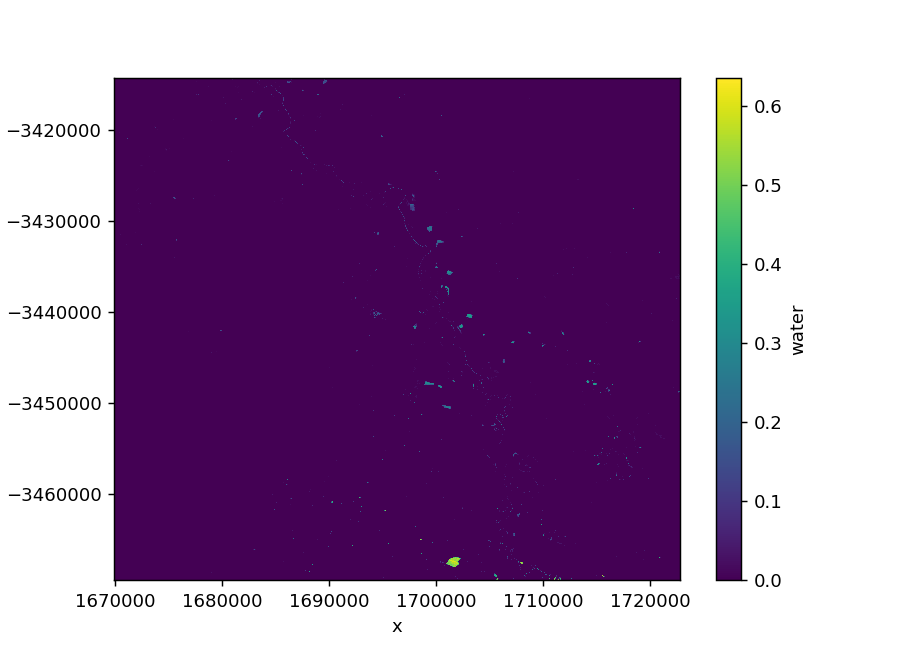

In [186]:
fig = plt.figure(figsize=(7, 5))
wofs.plot()

## Write out our wofs to .TIFF

In [8]:
wofsds = wofs.to_dataset()
wofsds.attrs['affine'] = WOFL.affine
wofsds.attrs['crs'] = WOFL.crs
write_geotiff(WOFS_TIFF, wofsds)

## We want to use the seasonal percentage wet data to generate a series of polygons

### First, filter the raster based on values >0.05
I.e. where water is observed at least 5% of the time

In [187]:
WOFSfiltered = wofs > 0.05

<IPython.core.display.Javascript object>


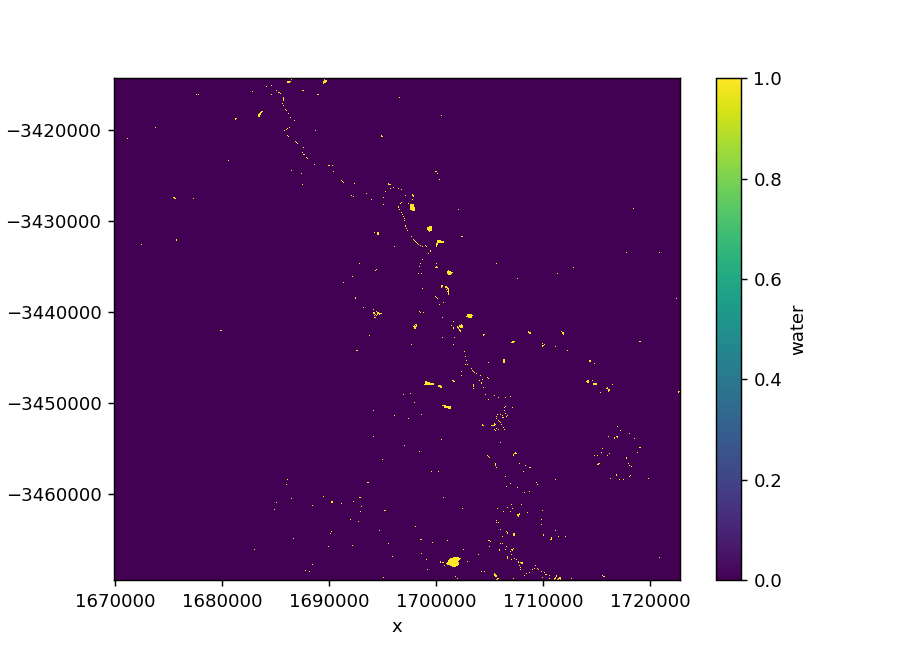

In [257]:
fig = plt.figure(figsize=(7, 5))
WOFSfiltered.plot()

## Convert the raster to polygons

In [275]:
WOFSpolygons = rasterio.features.shapes(WOFSfiltered.data.astype('float32'), transform = WOFL.affine)
WOFSlist = list(WOFSpolygons)

### Remove the giant zero polygon

In [277]:
RemoveZero = [i for i, x in enumerate(WOFSlist) if x[1] == 1]
RemoveZeroWOFS = [WOFSlist[x] for x in RemoveZero]

## Calculate the area of each polygon

In [288]:
WOFLshapes = []
for i, WOFLshape in enumerate(RemoveZeroWOFS):
    polyArea = Polygon(WOFLshape[0]['coordinates'][0]).area
    WOFLshape[0]['properties'] = {'area': polyArea}
    WOFLshapes.append(WOFLshape)

### Filter out any polygons smaller than two pixels

In [313]:
AreasIndex = [i for i, x in enumerate(WOFLshapes) if x[0]['properties']['area'] > 1250]
WOFSOFSbig = [WOFLshapes[x] for x in AreasIndex]

### Remove the superfluous extra value in the tuple

## Remove any polygons that intersect with a major river

We are only interested in farm dams, so do not need the WOFS polygons for the rivers

In [ ]:
MajorRivers = gp.GeoDataFrame.from_file('/g/data/r78/cek156/dea-notebooks/SurfaceHydrologyLinesRegionalFilteredMAJOR.shp') 

In [316]:
from shapely.geometry import Polygon, shape

WOFSOFSbreaktuple = [a for a, b in list(WOFSOFSbig)]

# Grab the geometeries
for poly in WOFSOFSbreaktuple:
    poly['geometry'] = shape(poly)
    
WOFSOFSfiltered2p0 = gp.GeoDataFrame(WOFSOFSbreaktuple).set_geometry('geometry')
Intersections= gp.sjoin(MajorRivers, WOFSOFSfiltered2p0, how="inner", op='intersects')
IntersectIndex = sorted(list(set(Intersections['index_right'])))

WOFSOFS = [WOFSOFSbreaktuple[x] for x in range(len(WOFSOFSbreaktuple)) 
                                  if x not in IntersectIndex]

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/geopandas/tools/sjoin.py:53: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [317]:
WOFSOFS

[{'type': 'Polygon',
  'coordinates': [[(1695750.0, -3414325.0),
    (1695750.0, -3414350.0),
    (1695775.0, -3414350.0),
    (1695775.0, -3414375.0),
    (1695825.0, -3414375.0),
    (1695825.0, -3414400.0),
    (1695850.0, -3414400.0),
    (1695850.0, -3414325.0),
    (1695750.0, -3414325.0)]],
  'properties': {'area': 5000.0},
  'geometry': <shapely.geometry.polygon.Polygon at 0x7fc9eaa57128>},
 {'type': 'Polygon',
  'coordinates': [[(1683475.0, -3414375.0),
    (1683475.0, -3414425.0),
    (1683525.0, -3414425.0),
    (1683525.0, -3414375.0),
    (1683475.0, -3414375.0)]],
  'properties': {'area': 2500.0},
  'geometry': <shapely.geometry.polygon.Polygon at 0x7fc9eaa578d0>},
 {'type': 'Polygon',
  'coordinates': [[(1683500.0, -3414625.0),
    (1683500.0, -3414700.0),
    (1683525.0, -3414700.0),
    (1683525.0, -3414625.0),
    (1683500.0, -3414625.0)]],
  'properties': {'area': 1875.0},
  'geometry': <shapely.geometry.polygon.Polygon at 0x7fc9eab45390>},
 {'type': 'Polygon',
  'co

<IPython.core.display.Javascript object>


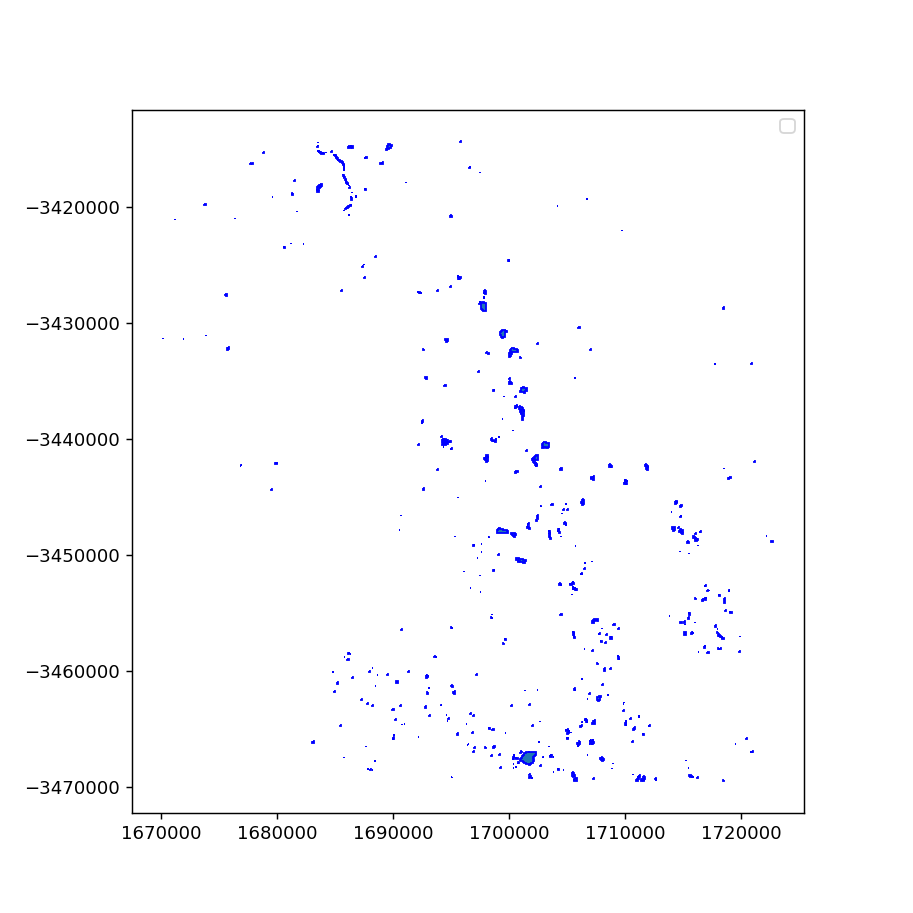

No handles with labels found to put in legend.


In [319]:
from descartes import PolygonPatch

fig = plt.figure(figsize = [7,7])
ax = fig.gca()
for i in range(len(WOFSOFS)):
    ax.add_patch(PolygonPatch(WOFSOFS[i], edgecolor = 'b', facecolor = None))
ax.axis('scaled')
plt.draw()
plt.show()
plt.legend()

## Remove river??